In [1]:
%matplotlib inline
import numpy as n
import matplotlib.pyplot as p
import healpy as hp
pi=n.pi
import copy
import scipy.optimize as op
c=299792458.
import astropy.io.fits as fits

In [2]:
fList=n.arange(50,210,10)

In [3]:
#take a cut through a beam
def hpCut(phi,nPix,data):
    nSide=hp.npix2nside(len(data))
    output=n.zeros(nPix)
    thetaVals=n.arange(nPix/2)/(nPix/2.)*pi/2.
    thetaVals=n.hstack([n.flipud(thetaVals),thetaVals,]).T
    phiVals=n.ones(len(thetaVals))
    phi1=phi+pi
    phiVals[:nPix/2]=phi1
    phiVals[nPix/2:]=phi
    output=hp.get_interp_val(data,thetaVals,phiVals)
    return output


#rotate
def rotateBeam(inputMap,rot=[90,0,0]):
    rotator=hp.Rotator(rot=rot)
    npix=len(inputMap)
    nside=hp.npix2nside(npix)
    theta,phi=hp.pix2ang(nside,range(npix))
    newtheta,newphi=rotator(theta,phi)
    output=hp.get_interp_val(inputMap,newtheta,newphi)
    return output
    


class Beam:
    def __init__(self,dirName,fList,nside,pols=['XX','YY'],rotateY=False,invert=False):
        self.nf=len(fList)
        self.fAxis=n.zeros(self.nf)
        self.npolsOriginal=len(pols)
        self.npols=max(len(pols),2)
        self.solidAngles=n.zeros((self.npols,self.nf))
        self.effArea=n.zeros_like(self.solidAngles)
        self.ellipticity=n.zeros(self.nf)
        self.nPix=hp.nside2npix(nside)
        self.nSide=nside
        self.pixArea=hp.nside2pixarea(self.nSide)

        
        theta,phi=hp.pix2ang(self.nSide,range(self.nPix))
        theta=n.round(n.degrees(theta)).astype(int)
        phi=n.round(n.degrees(phi)).astype(int)
        self.data=n.zeros((self.npols,self.nf,self.nPix))
        if(rotateY):
            pols.append('YY')
        self.pols=pols
        for m in range(self.nf):
            print m
            tempf=fList[m].split('p')
            self.fAxis[m]=float(tempf[0])*1e6
            if(len(tempf)>1):
                self.fAxis[m]+=float(tempf[1])/10.**(len(tempf[1]))*1e6
            for np in range(self.npolsOriginal):
                data=n.loadtxt('../data/beams/%s/%s_%s_%s.txt'%(dirName,dirName,fList[m],self.pols[np]),skiprows=2);
                self.data[np,m,:]=10**((data[:,2].squeeze().reshape(360,181))[phi,theta]/10.)
                if(invert):
                    self.data[np,m,:]=rotateBeam(self.data[np,m,:].flatten(),rot=[0,180,0])
                self.data[np,m,:]/=self.data[np,m,:].flatten().max(); 
                self.data[np,m,theta>90.]=0.
                self.solidAngles[np,m]=self.pixArea*n.sum(self.data[np,m,:])
                self.effArea[np,m]=(c/(self.fAxis[m]))**2./self.solidAngles[np,m]
            if(self.npolsOriginal==1):
                self.data[1,m,:]=rotateBeam(self.data[0,m,:].flatten())
                self.solidAngles[1,m]=self.pixArea*n.sum(self.data[1,m,:])
                self.effArea[1,m]=(c/(self.fAxis[m]))**2./self.solidAngles[1,m]
            if(len(self.pols)>1 and self.pols[0]=='XX' and self.pols[1]=='YY'):
                self.ellipticity[m]=n.sum((self.data[0,m]-self.data[1,m])**2.)/n.sum((self.data[0,m]+self.data[1,m])**2.)

                
                
class FeedData:
    def __init__(self,dirName,dirNameFeedOnly,fList,nside,pols=['XX','YY'],rotateY=False,invertFeedOnly=True,invertDish=False,dDish=14.,dFocus=4.5):
        self.nf=len(fList)
        self.nSide=nside
        self.nPix=hp.nside2npix(nside)
        self.daveFeedEfficiency=n.zeros(self.nf)
        self.daveTaper=n.zeros(self.nf)
        self.davePol=n.zeros(self.nf)
        self.daveBeamEfficiency=n.zeros(self.nf)
        self.dDish=dDish
        self.dFocus=dFocus
        self.thetaEdge=2.*n.arctan(self.dDish/(4.*self.dFocus))
        self.beamFeedAndDish=Beam(dirName,fList,nside,copy.deepcopy(pols),rotateY,invertDish)
        self.beamFeedOnly=Beam(dirNameFeedOnly,fList,nside,pols,rotateY,invertFeedOnly)
        self.fAxis=self.beamFeedOnly.fAxis
        self.beamFWHM=n.zeros(len(self.fAxis))
        self.gain=4.*pi/self.beamFeedAndDish.solidAngles[0,:]
        theta,phi=hp.pix2ang(self.nSide,range(self.nPix))


        self.nSide=nside
        self.nPix=hp.nside2npix(self.nSide)
        self.pols=self.beamFeedAndDish.pols
        for mm in range(self.nf):
            dataFeed=self.beamFeedOnly.data[0,mm,:]
            dataDish=self.beamFeedAndDish.data[0,mm,:]
            #compute feed efficiency by integrating feed beam intercepted by dish
            selectionEdge=theta<self.thetaEdge
            self.daveFeedEfficiency[mm]=n.sum(dataFeed[selectionEdge])/n.sum(dataFeed)
            #compute taper by averaging gain on ring at dish edge
            phiRange=n.radians(n.arange(0,360))
            thetaRange=n.ones(len(phiRange))*self.thetaEdge
            self.daveTaper[mm]=1./n.mean(hp.get_interp_val(dataFeed,thetaRange,phiRange))
            #compute polarization mismatch by integrating phi=0 and phi=90
            thetaRange=n.radians(n.arange(0,180))
            phiRange=n.ones(len(thetaRange))*0.
            xArc=hp.get_interp_val(dataDish,thetaRange,phiRange)
            yArc=hp.get_interp_val(dataDish,thetaRange,phiRange+pi/2.)
            self.davePol[mm]=n.sum((n.sqrt(xArc)-n.sqrt(yArc))**2.)/n.sum((n.sqrt(xArc)+n.sqrt(yArc))**2.)
            #compute beam efficiency. First determine FWHM by taking average in 360 degree ring. 
            stddevs=[]
            nth=1000
            tha=n.arange(-nth/2,nth/2)*pi/nth
            for nn in range(0,180,10):
                cut=hpCut(n.radians(nn),nth,dataDish)
                try:
                    stddevs.append(op.curve_fit(lambda x,p: n.exp(-x**2./(2.*p**2.)),tha,cut,p0=[n.radians(15.)])[0])
                except:
                    print 'error'
            stddeves=n.array(stddevs)
            stddev=n.max(stddevs)
            fwhm=2.*n.sqrt(2.*n.log(2.))*stddev
            print n.degrees(fwhm)
            self.beamFWHM[mm]=fwhm
            selectionFWHM=theta<fwhm/2.
            self.daveBeamEfficiency[mm]=n.sum(dataDish[selectionFWHM])/n.sum(dataDish)

In [4]:
#beamCylinder=Beam('beamCylinder',['100'],64)
fstrList=['050','060','070','080','090','100','110','120','130','140','150']
fstrListHigh=['100','110','120','130','140','150','160','170','180','190','200']



FeedHighBand=FeedData('beamHighBand','beamHighBandFeedOnly',fstrListHigh,64,['XX'],rotateY=True,invertFeedOnly=False)
FeedPickets=FeedData('beamPaneledCylinder','beamPicketCylinderFeedOnly_v2',fstrList,64,['XX'],rotateY=True)
FeedCylinder=FeedData('beamCylinderBackPlane_v2','beamCylinderFeedOnly_v2',fstrList,64,['XX'],rotateY=True)
FeedBackPlane=FeedData('beamBackPlane_v2','beamBackPlaneFeedOnly_v2',fstrList,64,['XX'],rotateY=True)
FeedCylinderAdaptive=FeedData('beamCylinderBackPlaneAdaptive_v2','beamCylinderFeedOnly_v2',fstrList,64,['XX'],rotateY=True)
FeedCylinderShortNoGap=FeedData('beamCylinderBackPlaneShortNoGap_v2','beamCylinderBackPlaneShortNoGapFeedOnly_v2',fstrList,64,['XX'],rotateY=True)
FeedCylinderShortGap=FeedData('beamCylinderBackPlaneShortGap_v2','beamCylinderBackPlaneShortGapFeedOnly',fstrList,64,['XX'],rotateY=True)
FeedCylinderNoGap=FeedData('beamCylinderBackPlaneNoGap_v2','beamCylinderBackPlaneNoGapFeedOnly_v2',fstrList,64,['XX'],rotateY=True)
FeedBareDipole=FeedData('beamBareDipole_v2','beamBareDipoleFeedOnly_v2',fstrList,64,['XX'],rotateY=True)



0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
15.133948655
15.7697866398
14.1415049477
12.1212992983
12.4422507927
13.085118217
12.58602229
10.9111358491
10.6640580235
12.3896003575
11.7942122302
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
27.5592953308
24.0678915063
19.7846923242
16.705531832
16.7753021037
15.6453897366
14.6828806874
13.817534242
18.0457649541
13.2786892096
24.4334494535
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
26.5792320499
23.1696130616
21.1705096403
17.0555692275
16.4100300466
16.2936846406
15.6933722343
12.9046459664
13.8788491676
14.840610607
26.990961431
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
error
error
error
error
error
error
error
error
error
error
error
error
error
109.089962397
24.3254768417
22.4417789184
19.4870513744
17.2138180496
15.7574845308
15.054919999
13.2878420089
13.2636798057
12.0526097256
20.8844410518
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
26.5024811854
23.1685839861
21.1769685106
17.0557303284
16.4109959585
16.2691384622
1

In [9]:
def areaSq(feedModel):
    return (feedModel.beamFeedAndDish.data[0,6,:]**2.).sum()*feedModel.beamFeedAndDish.pixArea

In [11]:


for feed in [FeedPickets,
             FeedCylinder,
             FeedBackPlane,
             FeedCylinderShortNoGap,
             FeedCylinderShortGap,
             FeedCylinderNoGap,
             FeedBareDipole]:
    print areaSq(feed)



0.0337676868671
0.0363576582083
0.0298992126072
0.0296089580776
0.0292476292238
0.0360530698656
0.0289696475686


In [10]:
print (FeedCylinder.beamFeedAndDish.data[0,6,:].sum())*FeedCylinder.beamFeedAndDish.pixArea
print ((FeedCylinder.beamFeedAndDish.data[0,6,:]**2.).sum())*FeedCylinder.beamFeedAndDish.pixArea

print (FeedHighBand.beamFeedAndDish.data[0,6,:].sum())*FeedCylinder.beamFeedAndDish.pixArea
print ((FeedHighBand.beamFeedAndDish.data[0,6,:]**2.).sum())*FeedCylinder.beamFeedAndDish.pixArea


#print (FeedCylinder.beamFeedAndDish.data[0,6,:]**2.).sum()*hp.



0.0947882892421
0.0363576582083
0.0591499893422
0.0227753292735


In [8]:
rootdir='/Users/aaronew/Dropbox/PRISimBeams/'
beams_dir='/beamCylinderLow/'
outfile = rootdir + beams_dir + 'beamCylinderLow.hmap'
dx=FeedCylinder.beamFeedAndDish.data[0,6,:].reshape(-1,1)
dy=FeedCylinder.beamFeedAndDish.data[1,6,:].reshape(-1,1)
hdulist = []
hdulist += [fits.PrimaryHDU()]
hdulist[0].header['EXTNAME'] = 'PRIMARY'
hdulist[0].header['NPOL'] = (2, 'Number of polarizations')
hdulist[0].header['SOURCE'] = ('HERA-CST', 'Source of data')
nsides=[64,64]
pols=['X','Y']
schemes=['RING','RING']
freq=100e6
npixs=[len(dx),len(dy)]
for pi,pol in enumerate(pols):
    hdu = fits.ImageHDU([dx,dy][pi], name='BEAM_{0}'.format(pol))
    hdu.header['PIXTYPE'] = ('HEALPIX', 'Type of pixelization')
    hdu.header['ORDERING'] = (schemes[pi], 'Pixel ordering scheme, either RING or NESTED')
    hdu.header['NSIDE'] = (nsides[pi], 'NSIDE parameter of HEALPIX')
    hdu.header['NPIX'] = (npixs[pi], 'Number of HEALPIX pixels')
    hdu.header['FIRSTPIX'] = (0, 'First pixel # (0 based)')
    hdu.header['LASTPIX'] = (npixs[pi]-1, 'Last pixel # (0 based)')
    hdulist += [hdu]
    hdulist += [fits.ImageHDU([100e6], name='FREQS_{0}'.format(pol))]

outhdu = fits.HDUList(hdulist)
outhdu.writeto(outfile, clobber=True)


IOError: [Errno 2] No such file or directory: '/Users/aaronew/Dropbox/PRISimBeams//beamCylinderLow/beamCylinderLow.hmap'

In [13]:
rootdir='/Users/aaronew/Dropbox/PRISim_Beams/'
beams_dir='/beamCylinderLowNoGap/'
outfile = rootdir + beams_dir + 'beamCylinderLowNoGap.hmap'
dx=FeedCylinderNoGap.beamFeedAndDish.data[0,6,:].reshape(-1,1)
dy=FeedCylinderNoGap.beamFeedAndDish.data[1,6,:].reshape(-1,1)
hdulist = []
hdulist += [fits.PrimaryHDU()]
hdulist[0].header['EXTNAME'] = 'PRIMARY'
hdulist[0].header['NPOL'] = (2, 'Number of polarizations')
hdulist[0].header['SOURCE'] = ('HERA-CST', 'Source of data')
nsides=[64,64]
pols=['X','Y']
schemes=['RING','RING']
freq=100e6
npixs=[len(dx),len(dy)]
for pi,pol in enumerate(pols):
    hdu = fits.ImageHDU([dx,dy][pi], name='BEAM_{0}'.format(pol))
    hdu.header['PIXTYPE'] = ('HEALPIX', 'Type of pixelization')
    hdu.header['ORDERING'] = (schemes[pi], 'Pixel ordering scheme, either RING or NESTED')
    hdu.header['NSIDE'] = (nsides[pi], 'NSIDE parameter of HEALPIX')
    hdu.header['NPIX'] = (npixs[pi], 'Number of HEALPIX pixels')
    hdu.header['FIRSTPIX'] = (0, 'First pixel # (0 based)')
    hdu.header['LASTPIX'] = (npixs[pi]-1, 'Last pixel # (0 based)')
    hdulist += [hdu]
    hdulist += [fits.ImageHDU([100e6], name='FREQS_{0}'.format(pol))]

outhdu = fits.HDUList(hdulist)
outhdu.writeto(outfile, clobber=True)


In [14]:
rootdir='/Users/aaronew/Dropbox/PRISim_Beams/'
beams_dir='/beamBackPlane/'
outfile = rootdir + beams_dir + 'beamBackPlane.hmap'
dx=FeedBackPlane.beamFeedAndDish.data[0,6,:].reshape(-1,1)
dy=FeedBackPlane.beamFeedAndDish.data[1,6,:].reshape(-1,1)
hdulist = []
hdulist += [fits.PrimaryHDU()]
hdulist[0].header['EXTNAME'] = 'PRIMARY'
hdulist[0].header['NPOL'] = (2, 'Number of polarizations')
hdulist[0].header['SOURCE'] = ('HERA-CST', 'Source of data')
nsides=[64,64]
pols=['X','Y']
schemes=['RING','RING']
freq=100e6
npixs=[len(dx),len(dy)]
for pi,pol in enumerate(pols):
    hdu = fits.ImageHDU([dx,dy][pi], name='BEAM_{0}'.format(pol))
    hdu.header['PIXTYPE'] = ('HEALPIX', 'Type of pixelization')
    hdu.header['ORDERING'] = (schemes[pi], 'Pixel ordering scheme, either RING or NESTED')
    hdu.header['NSIDE'] = (nsides[pi], 'NSIDE parameter of HEALPIX')
    hdu.header['NPIX'] = (npixs[pi], 'Number of HEALPIX pixels')
    hdu.header['FIRSTPIX'] = (0, 'First pixel # (0 based)')
    hdu.header['LASTPIX'] = (npixs[pi]-1, 'Last pixel # (0 based)')
    hdulist += [hdu]
    hdulist += [fits.ImageHDU([100e6], name='FREQS_{0}'.format(pol))]

outhdu = fits.HDUList(hdulist)
outhdu.writeto(outfile, clobber=True)


In [5]:
rootdir='/Users/aaronew/Dropbox/PRISim_Beams/'
beams_dir='/beamDipoleLow/'
outfile = rootdir + beams_dir + 'beamDipoleLow.hmap'
dx=FeedBareDipole.beamFeedAndDish.data[0,6,:].reshape(-1,1)
dy=FeedBareDipole.beamFeedAndDish.data[1,6,:].reshape(-1,1)
hdulist = []
hdulist += [fits.PrimaryHDU()]
hdulist[0].header['EXTNAME'] = 'PRIMARY'
hdulist[0].header['NPOL'] = (2, 'Number of polarizations')
hdulist[0].header['SOURCE'] = ('HERA-CST', 'Source of data')
nsides=[64,64]
pols=['X','Y']
schemes=['RING','RING']
freq=100e6
npixs=[len(dx),len(dy)]
for pi,pol in enumerate(pols):
    hdu = fits.ImageHDU([dx,dy][pi], name='BEAM_{0}'.format(pol))
    hdu.header['PIXTYPE'] = ('HEALPIX', 'Type of pixelization')
    hdu.header['ORDERING'] = (schemes[pi], 'Pixel ordering scheme, either RING or NESTED')
    hdu.header['NSIDE'] = (nsides[pi], 'NSIDE parameter of HEALPIX')
    hdu.header['NPIX'] = (npixs[pi], 'Number of HEALPIX pixels')
    hdu.header['FIRSTPIX'] = (0, 'First pixel # (0 based)')
    hdu.header['LASTPIX'] = (npixs[pi]-1, 'Last pixel # (0 based)')
    hdulist += [hdu]
    hdulist += [fits.ImageHDU([100e6], name='FREQS_{0}'.format(pol))]

outhdu = fits.HDUList(hdulist)
outhdu.writeto(outfile, clobber=True)


In [9]:
rootdir='/Users/aaronew/Dropbox/PRISim_Beams/'
beams_dir='/beamCylinderLowShort/'
outfile = rootdir + beams_dir + 'beamCylinderLowShort.hmap'
dx=FeedCylinderShortGap.beamFeedAndDish.data[0,6,:].reshape(-1,1)
dy=FeedCylinderShortGap.beamFeedAndDish.data[1,6,:].reshape(-1,1)
hdulist = []
hdulist += [fits.PrimaryHDU()]
hdulist[0].header['EXTNAME'] = 'PRIMARY'
hdulist[0].header['NPOL'] = (2, 'Number of polarizations')
hdulist[0].header['SOURCE'] = ('HERA-CST', 'Source of data')
nsides=[64,64]
pols=['X','Y']
schemes=['RING','RING']
freq=100e6
npixs=[len(dx),len(dy)]
for pi,pol in enumerate(pols):
    hdu = fits.ImageHDU([dx,dy][pi], name='BEAM_{0}'.format(pol))
    hdu.header['PIXTYPE'] = ('HEALPIX', 'Type of pixelization')
    hdu.header['ORDERING'] = (schemes[pi], 'Pixel ordering scheme, either RING or NESTED')
    hdu.header['NSIDE'] = (nsides[pi], 'NSIDE parameter of HEALPIX')
    hdu.header['NPIX'] = (npixs[pi], 'Number of HEALPIX pixels')
    hdu.header['FIRSTPIX'] = (0, 'First pixel # (0 based)')
    hdu.header['LASTPIX'] = (npixs[pi]-1, 'Last pixel # (0 based)')
    hdulist += [hdu]
    hdulist += [fits.ImageHDU([100e6], name='FREQS_{0}'.format(pol))]

outhdu = fits.HDUList(hdulist)
outhdu.writeto(outfile, clobber=True)


In [19]:
rootdir='/Users/aaronew/Dropbox/PRISim_Beams/'
beams_dir='/beamPicketLow/'
outfile = rootdir + beams_dir + 'beamPicketLow.hmap'
dx=FeedPickets.beamFeedAndDish.data[0,6,:].reshape(-1,1)
dy=FeedPickets.beamFeedAndDish.data[1,6,:].reshape(-1,1)
hdulist = []
hdulist += [fits.PrimaryHDU()]
hdulist[0].header['EXTNAME'] = 'PRIMARY'
hdulist[0].header['NPOL'] = (2, 'Number of polarizations')
hdulist[0].header['SOURCE'] = ('HERA-CST', 'Source of data')
nsides=[64,64]
pols=['X','Y']
schemes=['RING','RING']
freq=100e6
npixs=[len(dx),len(dy)]
for pi,pol in enumerate(pols):
    hdu = fits.ImageHDU([dx,dy][pi], name='BEAM_{0}'.format(pol))
    hdu.header['PIXTYPE'] = ('HEALPIX', 'Type of pixelization')
    hdu.header['ORDERING'] = (schemes[pi], 'Pixel ordering scheme, either RING or NESTED')
    hdu.header['NSIDE'] = (nsides[pi], 'NSIDE parameter of HEALPIX')
    hdu.header['NPIX'] = (npixs[pi], 'Number of HEALPIX pixels')
    hdu.header['FIRSTPIX'] = (0, 'First pixel # (0 based)')
    hdu.header['LASTPIX'] = (npixs[pi]-1, 'Last pixel # (0 based)')
    hdulist += [hdu]
    hdulist += [fits.ImageHDU([100e6], name='FREQS_{0}'.format(pol))]

outhdu = fits.HDUList(hdulist)
outhdu.writeto(outfile, clobber=True)


In [11]:
rootdir='/Users/aaronew/Dropbox/PRISim_Beams/'
beams_dir='/beamCylinderLowShortNoGap/'
outfile = rootdir + beams_dir + 'beamCylinderLowShortNoGap.hmap'
dx=FeedCylinderShortNoGap.beamFeedAndDish.data[0,6,:].reshape(-1,1)
dy=FeedCylinderShortNoGap.beamFeedAndDish.data[1,6,:].reshape(-1,1)
hdulist = []
hdulist += [fits.PrimaryHDU()]
hdulist[0].header['EXTNAME'] = 'PRIMARY'
hdulist[0].header['NPOL'] = (2, 'Number of polarizations')
hdulist[0].header['SOURCE'] = ('HERA-CST', 'Source of data')
nsides=[64,64]
pols=['X','Y']
schemes=['RING','RING']
freq=100e6
npixs=[len(dx),len(dy)]
for pi,pol in enumerate(pols):
    hdu = fits.ImageHDU([dx,dy][pi], name='BEAM_{0}'.format(pol))
    hdu.header['PIXTYPE'] = ('HEALPIX', 'Type of pixelization')
    hdu.header['ORDERING'] = (schemes[pi], 'Pixel ordering scheme, either RING or NESTED')
    hdu.header['NSIDE'] = (nsides[pi], 'NSIDE parameter of HEALPIX')
    hdu.header['NPIX'] = (npixs[pi], 'Number of HEALPIX pixels')
    hdu.header['FIRSTPIX'] = (0, 'First pixel # (0 based)')
    hdu.header['LASTPIX'] = (npixs[pi]-1, 'Last pixel # (0 based)')
    hdulist += [hdu]
    hdulist += [fits.ImageHDU([100e6], name='FREQS_{0}'.format(pol))]

outhdu = fits.HDUList(hdulist)
outhdu.writeto(outfile, clobber=True)


In [8]:
rootdir='/Users/aaronew/Dropbox/PRISim_Beams/'
beams_dir='/beamCylinderHigh/'
outfile = rootdir + beams_dir + 'beamCylinderHigh.hmap'
dx=FeedHighBand.beamFeedAndDish.data[0,6,:].reshape(-1,1)
dy=FeedHighBand.beamFeedAndDish.data[1,6,:].reshape(-1,1)
hdulist = []
hdulist += [fits.PrimaryHDU()]
hdulist[0].header['EXTNAME'] = 'PRIMARY'
hdulist[0].header['NPOL'] = (2, 'Number of polarizations')
hdulist[0].header['SOURCE'] = ('HERA-CST', 'Source of data')
nsides=[64,64]
pols=['X','Y']
schemes=['RING','RING']
freq=100e6
npixs=[len(dx),len(dy)]
for pi,pol in enumerate(pols):
    hdu = fits.ImageHDU([dx,dy][pi], name='BEAM_{0}'.format(pol))
    hdu.header['PIXTYPE'] = ('HEALPIX', 'Type of pixelization')
    hdu.header['ORDERING'] = (schemes[pi], 'Pixel ordering scheme, either RING or NESTED')
    hdu.header['NSIDE'] = (nsides[pi], 'NSIDE parameter of HEALPIX')
    hdu.header['NPIX'] = (npixs[pi], 'Number of HEALPIX pixels')
    hdu.header['FIRSTPIX'] = (0, 'First pixel # (0 based)')
    hdu.header['LASTPIX'] = (npixs[pi]-1, 'Last pixel # (0 based)')
    hdulist += [hdu]
    hdulist += [fits.ImageHDU([100e6], name='FREQS_{0}'.format(pol))]

outhdu = fits.HDUList(hdulist)
outhdu.writeto(outfile, clobber=True)



/Users/aaronew/Python/default/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


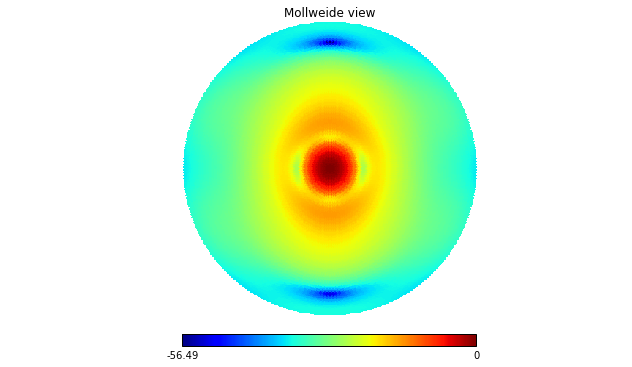

In [26]:
hp.mollview(10.*n.log10(dx.flatten()),rot=[0,90])